# User Location Classification in Hurricane Harvey
This is the second notebook in a series which are written primarily as a research logbook for the author. They are therefore not to be considered complete and do not represent the final analysis. For this -- see the final published papers and thesis, or contact the author directly.
The goal of this analysis is to evaluate methods by which users Tweeting about Hurricane Harvey may be classified as in the area or otherwise.

Data was collected with custom software which observed several Twitter streams and enhanced this information by querying the Twitter REST APIs for the network data (friends and followers) of each author. Stream volume which exceeded the capacity of the REST requests was discarded. 
* The keyword stream monitored the terms: [#harvey, #harveystorm, #hurricaneharvey, #corpuschristi]
* The GPS stream used the bounding box: [-99.9590682, 26.5486063, -93.9790001, 30.3893434]
* The collection period ran from 2017-08-26 01:32:18 until 2017-09-02 10:30:52 
* 55,605 Tweets by 33,585 unique authors were recorded

Data was coded using an interface built into the collection software by a primary coder. A secondary coder coded a sub-set of coded users for validation of the coding schema. User instances were coded by whether they 'appeared to be in the affected area'.

These notebooks access the data directly from the database using standard Django query syntax.


# Testing Community Detection Data

This section investigates the value of social network data in classifying users by the target class (witness/non-witness). The hypothesis, loosely, is that local (or witness) users are more likely to follow one another, and therefore the reflection of this behaviour within the network structure provides a metric which can be implemented within classification models. Collecting this network data is significantly more difficult than the other User and Tweet features, therefore the associative qualities are rarely tested.

The presence of this structure within the Hurricane Harvey dataset is visually established. The graph is then partitioned using a suite of community detection algorithms which provide metrics which are compatible with standard classification algorithms. These metrics are then tested for their correlation with the target feature to validate the use of community features in modelling, and to select the most appropriate algorithm. Finally, the algorithms are tested over subgraphs of the final dataset which represent the dataset at various points during the collection process.

<img src="./data/harvey_user_location/img/harvey-network-structure.png" alt="network-structure" style="width: 600px;"/>

A visual inspection of the follower/friend network of detected users (pictured above) shows a clear community structure. This suggests that there are certain user features that influence the propensity for a user to follow another user with similar features. These may be features which we have observed and recorded, or other features which we cannot predict. This can be tested by using community detection algorithms to partition the nodes of the graph into these communities, and then comparing these partitions to features with which they may be associated. Primarily, we are interested in whether these communities are related to whether a user is a 'witness' or not, as per our manual coding. If this is the case, the community metrics can be a useful feature in our models.

The image below shows a representation of the same network structure, where only the 1500 coded nodes are displayed in colours which represent their codes. The general grouping of orange nodes towards one section of the graph which corresponds with a community cluster shown in the original graph structure suggests that this community contains a greater proportion of witness nodes and therefore is a dependent feature. A preliminary hypothesis is that local users are more likely to follow one another (thus forming this community) and are also more likely to be witnesses. If true, this community could accurately predict which users are local and therefore, more likely to be witnesses.

<img src="./data/harvey_user_location/img/harvey-network-structure-coded.png" alt="network-structure-coded" style="width: 600px;"/>

The following image shows the output of a community detection algorithm which has partitioned the graph. In this example, the pink community appears to represent the witness group shown in the previous image.

<img src="./data/harvey_user_location/img/harvey-network-structure-community.png" alt="network-structure-community" style="width: 600px;"/>

## Calculating Community Labels
In the following section, the original dataframe is enhanced with modularity metrics. These are features which are calculated based upon the graph structure of the user friend/follower network. There are a number of community detection algorithms, so a set of these have been calculated to be tested and compared for association to the target (witness) class.

Community metrics were calculated using the `networkx` implementations of `greedy_modularity_communities`, `label_propagation_communities`, `asyn_lpa_communities`, `asyn_fluidc` and `community_louvain` from the `community` package. These were chosen due to their common use for these applications as well as the availability of their implmentations within the package.

The graph includes all detected users (i.e. not their followers/friends unless they were also detected as authors) for a total of 31,496 nodes and 99,602 edges. Community detection was performed on subgraph representing the largest connected component of 17,958 nodes and 75,203 edges. 

As most algorithms require an undirected graph, the direction of relationships was ignored.

Communities are labelled as numbers according to their ranking in size (where 0 is the largest), thus the labels have some level of ordinality.

In [247]:
### Initialisation ###
import os
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = [6, 4]

# Location of data files
DIR = './data/harvey_user_location/'
GRAPH_DIR = DIR + 'graph_objs/'

EVENT_NAME = Event.objects.all()[0].name.replace(' ', '')
DF_FILENAME = 'df_users.csv'

# Confirm correct database is set in Django settings.py
if 'Harvey' not in EVENT_NAME:
    raise Exception('Event name mismatch -- check database set in Django')

In [210]:
def get_graph_object():
    ''' 
    Gets the graph object for the current event.
    Imports gexf file if extant, otherwise builds from database
    and saves as gexf file.
    '''
    FILENAME = 'network_data_{}_v1.gexf'.format(EVENT_NAME)
    try:
        # Load cached file if available
        G = nx.read_gexf(GRAPH_DIR + FILENAME)
        print('Importing existing graph object...')
    except:
        print('Creating new graph object...')
        classed_users = User.objects.filter(user_class__gte=1)
        edges = Relo.objects.filter(target_user__in=classed_users, source_user__in=classed_users, end_observed_at=None)
        G=nx.DiGraph()
        for node in classed_users:
            try:
                user_code = node.coding_for_user.filter(coding_id=1).exclude(data_code__name='To Be Coded')[0].data_code.name
            except:
                user_code = ''
            G.add_node(node.screen_name, user_class=node.user_class, user_code=user_code)
        edge_list = [(edge.source_user.screen_name, edge.target_user.screen_name) for edge in edges]
        G.add_edges_from(edge_list)
        # Write to file and re-import to bypass unresolved issue with community algorithms
        nx.write_gexf(G, GRAPH_DIR + FILENAME, prettyprint=True)
        G = nx.read_gexf(GRAPH_DIR + FILENAME)
    return G

In [3]:
# Modularity:   https://scholar.google.com/scholar?q=Finding+community+structure+in+very+large+networks
# Label Prop:   https://neo4j.com/docs/graph-algorithms/current/algorithms/label-propagation/#algorithms-label-propagation-sample
# Louvain:      https://github.com/taynaud/python-louvain/blob/master/docs/index.rst

#import networkx as nx
from networkx.algorithms.community import (greedy_modularity_communities, 
                                            label_propagation_communities, 
                                            asyn_lpa_communities, 
                                            asyn_fluidc, girvan_newman)
import community as community_louvain
from collections import Counter

def calc_community_metrics(G, filename=False):
    ''' 
    Returns a graph object enhanced with various community 
    metrics added as node attributes.
    If a filename is provided, imports a cached gexf file 
    with community values if extant, otherwise calculates 
    them and and saves as gexf file.
    '''
    
    FLIUD_COMMUNITIES_NUMBER = 8
    RETURN_GIANT_COMPONENT = True # Only return giant component as graph object
    
    # Load cached file if available
    if filename:
        try:
            G = nx.read_gexf(GRAPH_DIR + filename)
            print('Importing existing community graph object...')
            return G
        except:
            pass
    
    print('Calculating community metrics for graph. {} nodes and {} edges...'
              .format(len(G), G.number_of_edges()))

    # Create undirected graph (required for community detection):
    H = nx.Graph(G)

    # Get largest component
    Hcc = max(nx.connected_components(H), key=len)
    H0 = H.subgraph(Hcc)
    #H0 = nx.connected_component_subgraphs(H)[0]
    print('Largest component has {} nodes and {} edges.'
              .format(len(H0), H0.number_of_edges()))

    # Discard other components:
    if RETURN_GIANT_COMPONENT:
        G = G.subgraph(Hcc)

    # Get communities
    print('Calculating c_modularity...')
    c_modularity = list(greedy_modularity_communities(H0))
    print('Calculating c_label_prop...')
    c_label_prop = list(label_propagation_communities(H0))
    c_label_prop = sorted(c_label_prop, key=len, reverse=True)
    print('Calculating c_label_prop_asyn...')
    c_label_prop_asyn = list(asyn_lpa_communities(H0))
    c_label_prop_asyn = sorted(c_label_prop_asyn, key=len, reverse=True)
    print('Calculating c_fluid...')
    c_fluid = list(asyn_fluidc(H0, FLIUD_COMMUNITIES_NUMBER))
    c_fluid = sorted(c_fluid, key=len, reverse=True)
    # TOO SLOW:
    # print('Calculating c_girvan_newman...')
    # c_girvan_newman = list(girvan_newman(H0))
    print('Calculating c_louvain...')
    partition = community_louvain.best_partition(H0)
    # Rank indices by size
    counter = Counter(partition.values())
    ranking = sorted(counter, key=counter.get, reverse=True)
    partition_sorted = {k: ranking.index(v) for k, v in partition.items()}

    print('Adding data as node attributes...')
    # Add communities to node attributes:
    community_output_dict = {'c_modularity': c_modularity,
                            'c_label_prop': c_label_prop,
                            'c_label_prop_asyn': c_label_prop_asyn,
                            'c_fluid': c_fluid,
                            # 'c_girvan_newman': c_girvan_newman
                            }
    for key in community_output_dict:
        community_dict = {}
        for i, c in enumerate(community_output_dict[key]):
            for name in c:
                community_dict[name] = i
        nx.set_node_attributes(G, community_dict, key)
    # (Louvain package returns a different format):
    nx.set_node_attributes(G, partition_sorted, 'c_louvain')

    if filename:
        print('Writing to file...')
        nx.write_gexf(G, GRAPH_DIR + filename, prettyprint=True)
        
    return G

In [4]:
e = Event.objects.all()[0]
filename = 'network_data_{}_comm.gexf'.format(e.name.replace(' ', ''))

G = get_graph_object()
G = calc_community_metrics(G, filename)

# Create datagrame from graph node attributes
nodes = G.nodes(data=True)
df_comm = pd.DataFrame.from_dict(dict(nodes), orient='index')
df_comm = df_comm.drop(['user_class', 'user_code', 'label'], axis=1)
#df_comm = df_comm.reset_index(drop=True)
df_comm.head()

Importing existing graph object...
Importing existing community graph object...


,c_modularity,c_label_prop,c_label_prop_asyn,c_fluid,c_louvain
0044Tamil,2,4,885,7,9
007rogerbmoore,3,0,955,7,0
01fmoreira,3,0,0,7,6
0KTOBR,5,2,3,1,3
0x41_0x48,241,885,106,6,0


In [243]:
# Open original Dataframe
users_df = pd.read_csv(DIR + DF_FILENAME, index_col=0)

users_df.shape

(1500, 45)

In [244]:
# Create list of community algorithm column names
comm_cols = list(df_comm.columns)

# Merge dataframes
users_df = pd.merge(left=users_df, right=df_comm, how='left', left_on='screen_name', right_index=True)

users_df.head()

,added_at,betweenness_centrality,closeness_centrality,created_at,default_profile,default_profile_image,degree_centrality,description,eigenvector_centrality,favourites_count,...,has_url,changed_screen_name,account_age,day_of_detection,is_data_source_3,c_modularity,c_label_prop,c_label_prop_asyn,c_fluid,c_louvain
0,2017-08-28 20:42:59.273657+00:00,0.000043,0.135798,2013-03-01 19:23:11+00:00,0,0,0.000304,If You Want To Live A Happy Life ❇ change your...,3.905631e-07,2030,...,0,0,1645,3,0,NaN,NaN,NaN,NaN,NaN
1,2017-08-30 13:58:20.296918+00:00,0.000015,0.122066,2014-01-20 00:34:57+00:00,1,0,0.000243,Employee Giving PM @Microsoft.A daydreamer w/ ...,1.785776e-07,1015,...,1,0,1321,5,0,NaN,NaN,NaN,NaN,NaN
2,2017-08-26 19:51:45.107222+00:00,0.000000,0.077120,2012-07-24 13:47:47+00:00,0,0,0.000061,Making an impact isn’t something reserved for ...,8.518251e-14,12,...,1,0,1865,1,1,NaN,NaN,NaN,NaN,NaN
3,2017-08-26 11:13:05.769123+00:00,0.000383,0.167070,2010-12-16 17:30:04+00:00,0,0,0.000668,Eyeing global entropy through a timeline windo...,4.315565e-05,347,...,1,0,2451,1,0,0.0,31.0,20.0,5.0,5.0
4,2017-08-26 14:19:23.604361+00:00,NaN,NaN,2009-04-24 12:08:14+00:00,0,0,NaN,Producer. Show Control Designer. Project Coord...,NaN,25,...,0,0,3052,1,0,NaN,NaN,NaN,NaN,NaN


## Evaluating Community Metrics

Some algorithms create many small communities of 1-10 members, which will not be useful in generalisation of the model. Therefore discarding these is useful.

Chi-square tests are typically recommended to require contingency tables with values of at least 5, which is addressed (in part) by this step. Note that this does not elimnate all relevant cells in the confusion matrix -- e.g. a row with 5 positive and 0 negative should be excluded from chi-square statistics as the negative cell has a frequency <5. This is therefore properly sorted below.

In [7]:
import numpy as np
    
# Ignore small communities where observed cases are too low (required for chi-square tests)
MIN_COMMUNITY_SIZE = 10

for col in comm_cols:
    s = users_df[col].value_counts()
    #s = users_df.loc[users_df['coded_as_witness']==1, col].value_counts()
    users_df.loc[~users_df[col].isin(s.index[s >= MIN_COMMUNITY_SIZE]), col] = np.NaN

In [8]:
X = users_df[comm_cols]
y = users_df['coded_as_witness']

As a preliminary visual investigation into the relationship between community and code, we can check the proportion of nodes within a community that are coded as positive cases (witnesses). In an independent case, we would expect these ratios to be similar, and reflect the overall ratio of cases, which is:
$$\frac{386}{1500} = 0.257$$
This is shown as a dotted line on the plots below.

In [170]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [6, 4]


def create_plot_grid(df_list, df_list_secondary=None, titles=None, axhline=None, kind='bar'):
    '''
    Plots a list of dataframes or series in a single figure 
    with two columns.
    
    Plots a secondary value on a different scale if 
    df_list_secondary is passed. Either as a matching list,
    or list containing a single series.
    
    Can add a horizontal line at a value provided as axhline.
    '''

    # If df_list are series, use series names as titles
    if not titles:
        try:
            titles = [x.name for x in df_list]
        except:
            pass
    
    # Plot single chart without grid:
    if len(df_list) == 1:
        if titles:
            df_list[0].plot(kind=kind, colormap='Spectral', title=titles[0], rot=45)
            #ax.set_title(titles[0])
        else:
            df_list[0].plot(kind=kind, colormap='Spectral', rot=45)
        if not df_list_secondary == None:
            df_list_secondary[0].plot(kind=kind, secondary_y=True, legend=True)
        return
    
    # Create grid structure:
    ncol = 2
    nrow = int((len(df_list)+1)/2)
    # Temporarilty increase figsize:
    plt.rcParams['figure.figsize'] = [plt.rcParams['figure.figsize'][0] * 2, 
                                      plt.rcParams['figure.figsize'][1] * nrow]
    fig, axs = plt.subplots(nrow, ncol)
    fig.tight_layout(pad=4.0)
    # Delete last cell if odd number:
    if len(df_list) % 2 != 0:
        fig.delaxes(axs[nrow-1,1])
    
    # Populate grid with plots:
    for r in range(nrow):
        for c in range(ncol):
            count = r*2+c
            # Prevent trying last cell if odd length
            if count == len(df_list):
                break
            # Handle missing index dimensions for 2x1 grid
            if len(df_list) == 2:
                ax = axs[c]
            else:
                ax = axs[r,c]

            df_list[count].plot(kind=kind, ax=ax, colormap='Spectral', rot=45)
            if not df_list_secondary == None:
                try:
                    df_list_secondary[count].plot(kind=kind, ax=ax, secondary_y=True, legend=True)
                except: # One secondary series passed for all plots
                    df_list_secondary[0].plot(kind=kind, ax=ax, secondary_y=True, legend=True)
            
            if titles:
                #ax.set_title(titles[count])
                ax.text(.5, .9, titles[count], 
                            horizontalalignment='center', 
                            transform=ax.transAxes, 
                            bbox=dict(facecolor='Grey', alpha=0.5))
            if axhline:
                axs[r,c].axhline(y=axhline, color='b', linestyle='dotted', lw=2)
    
    # Reset figsize:
    plt.rcParams['figure.figsize'] = [plt.rcParams['figure.figsize'][0] / 2, 
                                      plt.rcParams['figure.figsize'][1] / nrow]
    return

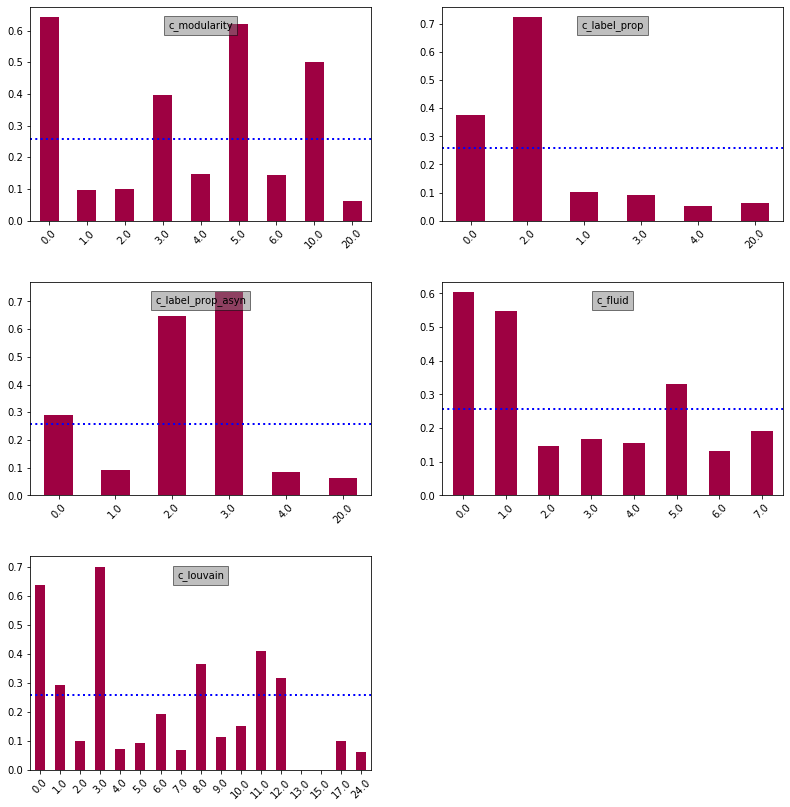

In [10]:
# Create dataframe for ratio of positive cases per community class, for each community algorithm
df_list = [users_df.loc[users_df['coded_as_witness']==1, col].dropna().value_counts() / 
               users_df[col].dropna().value_counts() 
               for col in comm_cols]

# Calculate expected proportion of positive cases given independence:
exp_pos_proportion = users_df['coded_as_witness'].value_counts()[1] / users_df.shape[0]

create_plot_grid(df_list, axhline=exp_pos_proportion)

From inspecting the graphs above, there appears to be a disproportionate amount of positive cases in certain communities, suggesting some association between community (as detected by a given algorithm) and the classification. Therefore, it is likely that including these metrics will increase the information available to the predictive models.

The charts shown above suggest that the highest proportion of positive classes appear in the largest, or second-largest communities (as the labels have been ranked in order of size). This is significant -- a model cannot be trained on community label as a feature, as the labels are qualitative and will be different each time an algorithm runs on a network. Therefore these features cannot generalise to new datasets. The feature that is supplied must therefore be something which is generalisable; in this case, the ranking of the community by size my be appropriate (for example, a feature which represents whether a user is in the largest detected community). Alternatively, communities may exhibit different characteristics such as connectedness. This will be explored later. The higher proportions seen in some of the later communities are less relevant as these are of a much smaller size. Thus the high proportions are 'easier' to achieve, and as smaller communities are more likely to represent unique cases, they are less likely to generalise.

The next steps in the analyis of the validity of this approach is the calculate whether the disparities observed above are statistically significant. That is, whether these associations could have been observed by chance.

Formally, for each community detection algorithm, we are testing the hypotheses:
$$H_0: \text{There is no association between the community label and witness label}$$
$$H_A: \text{There is an association between the community label and witness label}$$

### Chi-Square
A chi-squre analysis is performed on the output of each detection algorithm with the target class. Note that communities with a size below 5 are removed as per the recommendation for chi-square analysis.

In [11]:
import scipy.stats as scs

def chi_square(X, y):
    '''
    Calculate chi-square statistic between two rows.
    Eliminates rows where cell value is below threshold
    as per chi-square recommendation.
    Note: Automatically drops NaN rows
    '''
    
    MIN_CELL_VAL = 5
    
    confusion_matrix = pd.crosstab(X, y)
    # Eliminate rows where observed cases are below threshold:
    confusion_matrix = confusion_matrix[(confusion_matrix >= MIN_CELL_VAL).all(1)]
    # Check dimensions, as eliminating shorter rows is preferred.
    if confusion_matrix.shape[0] < confusion_matrix.shape[1]:
        print('WARNING: check passed series order -- cell elimination performed row-wise. r={}, c={}'
                  .format(confusion_matrix.shape[0], confusion_matrix.shape[1]))
    
    # Eliminate rows where expected values are below threshold:
    exp_matrix = pd.DataFrame(scs.chi2_contingency(confusion_matrix)[3])
    exp_matrix.index = confusion_matrix.index
    
    # Repeat in case new cells become < threshold once rows are dropped
    while (exp_matrix >= MIN_CELL_VAL).all(1).all() == False:
        confusion_matrix = confusion_matrix[(exp_matrix >= MIN_CELL_VAL).all(1)]
        exp_matrix = pd.DataFrame(scs.chi2_contingency(confusion_matrix)[3])
        exp_matrix.index = confusion_matrix.index
    
    return scs.chi2_contingency(confusion_matrix)


In [12]:
def get_chi2_df(X, y):
    cols = X.columns
    data = [list(chi_square(X[col], y)[:2]) for col in cols]
    chi2a_df = pd.DataFrame(data=data, columns=['chi-sq-a', 'chi-sq-a p-val'], index = cols)
    return chi2a_df

chi2a_df = get_chi2_df(X, y)
chi2a_df

,chi-sq-a,chi-sq-a p-val
c_modularity,203.524168,5.005149e-42
c_label_prop,76.213552,2.821223e-17
c_label_prop_asyn,125.452639,5.163057e-27
c_fluid,154.292529,5.088985e-30
c_louvain,207.972027,1.644365e-38


For all features, the analysis produced a significant $\chi^2$ value, well beyond our $\alpha=0.05$. Therefore we can reject the null hypothesis and accept that the alternative: there is an association between community and witness status.

In the following cells, a number of other measures of association are tested, including the `sklearn` implementation of chi-square.

We are now interested in selecting the community algorithm which is most useful in class prediction.

### Chi-Square (sklearn)

In [13]:
from sklearn.feature_selection import chi2

# This method drops NaN rows for any column, so more data is lost
# temp_df = users_df[comm_cols + ['coded_as_witness']].dropna()

# X = temp_df[comm_cols]
# y = temp_df['coded_as_witness']

# chi2b_df = pd.DataFrame(data={'feature': comm_cols, 'chi-sq-b': chi2(X,y)[0], 'chi-sq-b p-val': chi2(X,y)[1]})
# #chi2b_df.plot(kind='bar', y='chi2', x='feature', rot=45)
# chi2b_df

# This method calculates each metric separately, so fewer rows are dropped.
def get_chi2_sklearn_df(X, y):
    cols = X.columns    
#     data = [[k[0] for k in chi2(
#                                 X[col].dropna().to_frame(), 
#                                 y[X[col].notna()]
#                                 )
#             ] for col in cols]
    
    data = []
    for col in cols:
        data.append( [k[0] for k in chi2(
                                X[col].dropna().to_frame(), 
                                y[X[col].notna()])])
    chi2b_df = pd.DataFrame(data=data, columns=['chi-sq-b', 'chi-sq-b p-val'], index=cols)
    return chi2b_df

chi2b_df = get_chi2_sklearn_df(X, y)
chi2b_df

,chi-sq-b,chi-sq-b p-val
c_modularity,55.752662,8.218691e-14
c_label_prop,52.367253,4.603366e-13
c_label_prop_asyn,2.756299,9.687211e-02
c_fluid,147.466040,6.206597e-34
c_louvain,295.778228,2.738891e-66


`sklearn.feature_selection.chi2` uses a different implementation of the chi-square formula, therefore these result differ from the results returned by `scipy.stats.scs.chi2_contingency`. Regardless, the each of the p-values is sufficiently small to reject the null hypothesis and accept that there is an association.

 A p-value close to zero means that our variables are very unlikely to be completely unassociated in some population. However, this does not mean the variables are strongly associated; a weak association in a large sample size may also result in p = 0.000.
 
 ### Cramer's V
 
Given that we would like to choose the algorithm which results in the communities with the strongest associations to the target label, we need another statistical measure. Cramérs $\phi$ (or V) coefficient is based upon the $\chi^2$ value and measures the strength the association between two categorical variables. Here, a score of $0$ represents no association, and $1$ represents a perfect association.

$${\phi}_c = \sqrt{\frac{\chi^2}{N(k-1)}}$$

In [14]:
import numpy as np

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    #chi2 = scs.chi2_contingency(confusion_matrix)[0]
    chi2 = chi_square(x, y)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [15]:
def get_cramers_df(X, y):
    cols = X.columns
    data = [cramers_v(X[col].dropna(), y[X[col].notna()]) for col in cols]
    cramers_df = pd.DataFrame(data=data, columns=['cramers_v'], index=cols)
    return cramers_df

cramers_df = get_cramers_df(X, y)
cramers_df

,cramers_v
c_modularity,0.499062
c_label_prop,0.331235
c_label_prop_asyn,0.467963
c_fluid,0.404088
c_louvain,0.474934


### Theil's U
While Cramer's Phi measures the strength of the association, Theil's U is a conditional measure. That is, it is able to measure how well we can predict one variable, given the other. Therefore, it is a more suitable statistic when evaluating features to use in prediction models.

In essence: 'given Y, what fraction of the bits of X can we predict?'


In [16]:
import math
from collections import Counter

def conditional_entropy(x, y, log_base: float = math.e):
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x, y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0.0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y / p_xy, log_base)
    return entropy

def theils_u(x, y):
    '''given Y, what fraction of the bits of X can we predict?'''
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = scs.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x

In [17]:
def get_theils_df(X, y):
    cols = X.columns
    # Swap X and y positions to match Theil format:
    data = [theils_u(y[X[col].notna()], X[col].dropna()) for col in cols]
    theils_df = pd.DataFrame(data=data, columns=['theils_u'], index=cols)
    return theils_df

theils_df = get_theils_df(X, y)
theils_df

,theils_u
c_modularity,0.228286
c_label_prop,0.142234
c_label_prop_asyn,0.233647
c_fluid,0.136705
c_louvain,0.258152


### Random Forest Feature Selection
Decision Trees (and their ensemble random forest counterparts) can rank features on their importance, where their importance represents how much reduction of the (gini) uncertainty measure each feature contributes to the model. Note that due to how decision trees learn, these importance values can vary each time a model is trained, though this variance should be minimised in ensemble methods.

In [18]:
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import warnings

# Ignore FutureWarning from RF classifier
warnings.simplefilter(action='ignore', category=FutureWarning)


def get_rf_importance_df(X, y):
    '''
    Returns importances of X variables as determined by
    random forest model.
    
    X: dataframe
    Y: series
    '''
    nan_rows = X.isna().any(1)
    y = y[~nan_rows]
    X = X[~nan_rows]

    #tree = DecisionTreeRegressor().fit(X, y)
    #tree = DecisionTreeClassifier().fit(X, y)
    tree = RandomForestClassifier(n_estimators=1000).fit(X, y)

    rf_df = pd.DataFrame(tree.feature_importances_, 
                   columns =['importance'], index=comm_cols)
    return rf_df


rf_df = get_rf_importance_df(users_df[comm_cols], users_df['coded_as_witness'])
#rf_df.plot(kind='bar', x='feature', rot=45)
rf_df 

,importance
c_modularity,0.242374
c_label_prop,0.074022
c_label_prop_asyn,0.167264
c_fluid,0.327971
c_louvain,0.188368


We can now compare the algorithms across each association measure. Theil's U and perhaps the random forest feature importance measures are more significant here. The Louvain and modularity measures appear to be the most promising. The asynchronous implementation of label propogation appears to outperform its synchronous counterpart, though it's overall relevance requires further investigation.

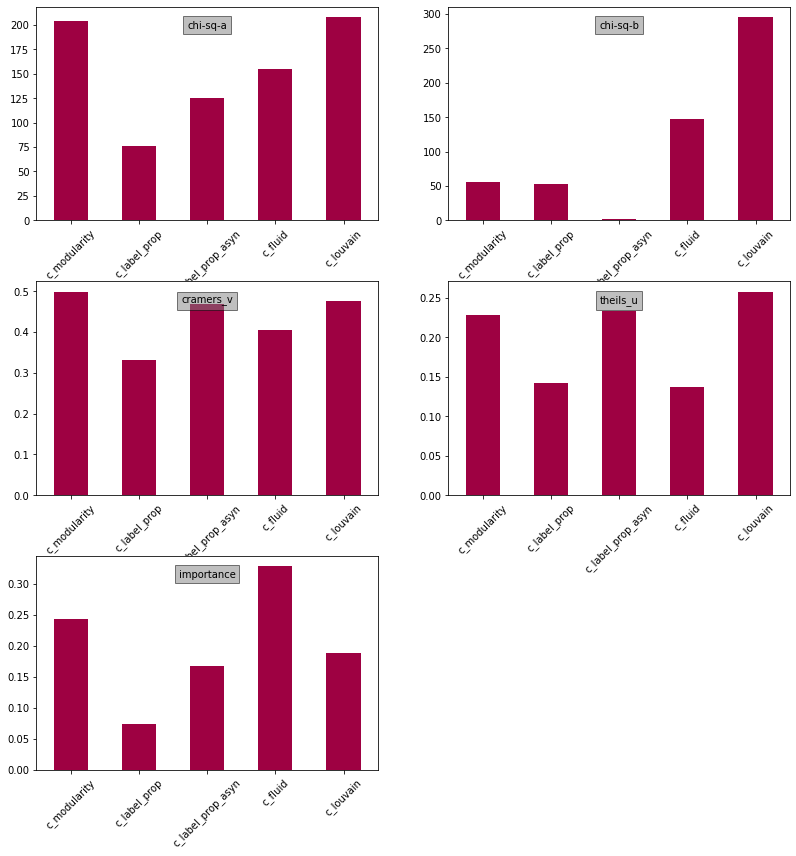

In [19]:
df_list = [chi2a_df, chi2b_df, cramers_df, theils_df, rf_df]
# Plot only first column:
df_list = [x.iloc[:,0] for x in df_list]

create_plot_grid(df_list)

## Evaluation on Temporal Sub-Graphs

While the analysis above demonstrates the predictive power of these algorithms at the end point of an event, once the graph data is most rich, the purpose of this research is to classify user objects as they are detected. Therefore, we need to test the efficacy of these algorithms on partial graphs, as they appeared throughout the data collection process.

Data was collected over the course of several days for this event, therefore we can create subgraphs at intervals an re-calculate the metrics discussed above. This function creates a subgraph as it existed at every 24-hour interval from the event start time. Therefore, for the Hurricane Harvey event, which was recorded over 7 days and 10 hours, 7 sub-graphs are generated. With the final graph, there are a total of 8 graphs. Each graph contains all the data of the graph preceding it plus the newly observed users and their common relationships.

The same transormations as above are then applied and the association measures calculated. It is expected that the measures increase over time, as the network structure is revealed. We are therefore interested in observing the rate at which this happens.

In [20]:
import networkx as nx
from datetime import timedelta

def get_graph_objects_time_sliced():
    """
    Creates subgraphs of the main event's graph every 24 hours 
    from start date.
    
    Sub-graphs are returned in a dictionary keyed by their
    slice index, where t_n = k*24h. The dictionary will not
    include the final, complete graph.
    """
    
    # Get event and calculate duration:
    e = Event.objects.all()[0]
    end = max(e.time_end, e.kw_stream_end, e.gps_stream_end)
    start = min(e.time_start, e.kw_stream_start, e.gps_stream_start)
    duration_days = (end - start).days
    print('Days in event: {}: {} '.format(e.name, duration_days))
    # Create timestamps every 24 hours:
    interim_time_slices = [start + timedelta(days=t+1) for t in range(duration_days)]
    # Reverse list to support progressively paring down subset queries:
    interim_time_slices.reverse()
    
    graph_dict = {}
    print('Getting user and edge list for full graph...')
    classed_users = User.objects.filter(user_class__gte=1)
    edges = Relo.objects.filter(target_user__in=classed_users, source_user__in=classed_users, end_observed_at=None)
    
    # Create subgraphs for each time stamp in reverse chronological order:
    for i in range(len(interim_time_slices)):
        filename = 'network_data_{}_tslice-{}.gexf'.format(EVENT_NAME, len(interim_time_slices)-i)
        try:
            # Load cached file if available
            G = nx.read_gexf(GRAPH_DIR + filename)
            print('Importing existing graph object for time slice {} ...'.format(i))
        except:
            print('Creating new graph object for time slice {}...'.format(i))
            # Subset classed users for those added prior to slice point:
            classed_users = classed_users.filter(added_at__lt=interim_time_slices[i])
            G=nx.DiGraph()
            for node in classed_users:
                try:
                    user_code = (node.coding_for_user.filter(coding_id=1)
                                .exclude(data_code__name='To Be Coded')[0]
                                .data_code.name)
                except:
                    user_code = ''
                G.add_node(node.screen_name, user_class=node.user_class, user_code=user_code)
            # Subset edges to those associated with subset of users
            edges = edges.filter(target_user__in=classed_users, 
                                    source_user__in=classed_users)
            edge_list = [(edge.source_user.screen_name, edge.target_user.screen_name) for edge in edges]
            G.add_edges_from(edge_list)
            # Write to file and re-import to bypass issue with community algorithms
            nx.write_gexf(G, GRAPH_DIR + filename, prettyprint=True)
            G = nx.read_gexf(GRAPH_DIR + filename)
            
        graph_dict[len(interim_time_slices)-i] = G
        
    return graph_dict

In [21]:
g_dict = get_graph_objects_time_sliced()

Days in event: Hurricane Harvey: 7 
Getting user and edge list for full graph...
Importing existing graph object for time slice 0 ...
Importing existing graph object for time slice 1 ...
Importing existing graph object for time slice 2 ...
Importing existing graph object for time slice 3 ...
Importing existing graph object for time slice 4 ...
Importing existing graph object for time slice 5 ...
Importing existing graph object for time slice 6 ...


In [189]:
########################################################
########################################################
########################################################
########################################################
########################################################
#### STOP HERE AND CHECK STATE OF users_df -- next section needn't import again and use temp, use copy instead.

#raise Exception

users_df.head()

Exception: 

Calculate the community metrics for each subgraph and create time slice dataframes for each metric:

In [22]:
# import os
# import pandas as pd
# # Ignore FutureWarning from RF classifier
# import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)

# users_df = pd.read_csv(DIR + DF_FILENAME, index_col=0)

# TODO: check this cell, move into function?

g_dict_comm = {}

tslice_chi2a_df = pd.DataFrame()
tslice_chi2b_df = pd.DataFrame()
tslice_cramers_df = pd.DataFrame()
tslice_theils_df = pd.DataFrame()
tslice_rf_df = pd.DataFrame()

    
# Calculate the community metrics for each subgraph:
for key in g_dict:
    print('Processing subgraph: ', key)
    e = Event.objects.all()[0]
    filename = 'network_data_{}_comm_tslice-{}.gexf'.format(e.name.replace(' ', ''), key)
    g2 = g_dict[key]
    
    # Write and reimport to avoid issue with community calculation:
    nx.write_gexf(g2, GRAPH_DIR + 'temp.gexf', prettyprint=True)
    g2 = nx.read_gexf(GRAPH_DIR + 'temp.gexf')
    os.remove(GRAPH_DIR + 'temp.gexf')
    
    # Calc community metrics for graph
    g2 = calc_community_metrics(g2, filename)
    g_dict_comm[key] = g2
    
    # Create community dataframe
    nodes = g2.nodes(data=True)
    df_comm = pd.DataFrame.from_dict(dict(nodes), orient='index')
    df_comm = df_comm.drop(['user_class', 'user_code', 'label'], axis=1)
    
    # Merge dataframes
    comm_cols = list(df_comm.columns)
    users_df_temp = pd.merge(left=users_df, right=df_comm, how='left', left_on='screen_name', right_index=True)

    # Ignore small communities where observed cases are too low (required for chi-square tests)
    MIN_COMMUNITY_SIZE = 5
    for col in comm_cols:
        s = users_df_temp[col].value_counts()
        users_df_temp.loc[~users_df_temp[col].isin(s.index[s >= MIN_COMMUNITY_SIZE]), col] = np.NaN

    X2 = users_df_temp[comm_cols]
    y2 = users_df_temp['coded_as_witness']
    # Chi-square
    tslice_chi2a_df[key] = get_chi2_df(X2, y2).iloc[:,0]
    # Chi-square sklearn
    tslice_chi2b_df[key] = get_chi2_sklearn_df(X2, y2).iloc[:,0]
    # Cramer's V
    tslice_cramers_df[key] = get_cramers_df(X2, y2).iloc[:,0]
    # Theil's U
    tslice_theils_df[key] = get_theils_df(X2, y2).iloc[:,0]
    # Random Forest
    tslice_rf_df[key] = get_rf_importance_df(X2, y2).iloc[:,0]

Processing subgraph:  7
Importing existing community graph object...
Processing subgraph:  6
Importing existing community graph object...
Processing subgraph:  5
Importing existing community graph object...
Processing subgraph:  4
Importing existing community graph object...
Processing subgraph:  3
Importing existing community graph object...
Processing subgraph:  2
Importing existing community graph object...
Processing subgraph:  1
Importing existing community graph object...


We can now inspect the rate of growth over the collection period. Edges are only included if they are connected to an existing user, therefore their growth should accelerate as the available users with which to connect increases.

,nodes,edges
0,0,0
1,2288,9990
2,3723,16733
3,6407,29516
4,10031,46996
5,13163,64469
6,16179,83982
7,18067,98005
final,18409,100257


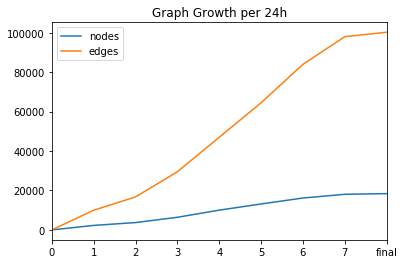

In [23]:
node_counts = pd.Series([len(g) for g in g_dict_comm.values()] + [0]).iloc[::-1].reset_index(drop=True)
node_counts.name = 'nodes'
edge_counts = pd.Series([g.number_of_edges() for g in g_dict_comm.values()] + [0]).iloc[::-1].reset_index(drop=True)
edge_counts.name = 'edges'
dff = pd.concat([node_counts, edge_counts], axis=1)

dff.loc['final'] = [len(G), G.number_of_edges()]
dff.plot(title='Graph Growth per 24h')
dff

In [24]:
# Sort columns chronologically:
dfs = [tslice_chi2a_df, tslice_chi2b_df, tslice_cramers_df, tslice_theils_df, tslice_rf_df]

for df in dfs:
    df.sort_index(axis=1, inplace=True)
    
# Append the final graph values to each dataframe:
tslice_chi2a_df['final'] = chi2a_df.iloc[:,0]
tslice_chi2b_df['final'] = chi2b_df.iloc[:,0]
tslice_cramers_df['final'] = cramers_df.iloc[:,0]
tslice_theils_df['final'] = theils_df.iloc[:,0]
tslice_rf_df['final'] = rf_df.iloc[:,0]

The association measures can now be viewed over the time slice periods. Their growth over time will illustrate the emergence of the graph structure as seen in the final graph. Where association measures are poor for early values if `t`,  modularity measures may not provide adequate predictive power in earlier graphs and therefore using the metrics may not be feasible in a live classification application. Ideally, the higher association measures will emerge early.

We expect the chi-square values to generally increase as the graph size increases; this does not represent an increasing association but is a function of the formula. They are presented here for reference.

chi-square a


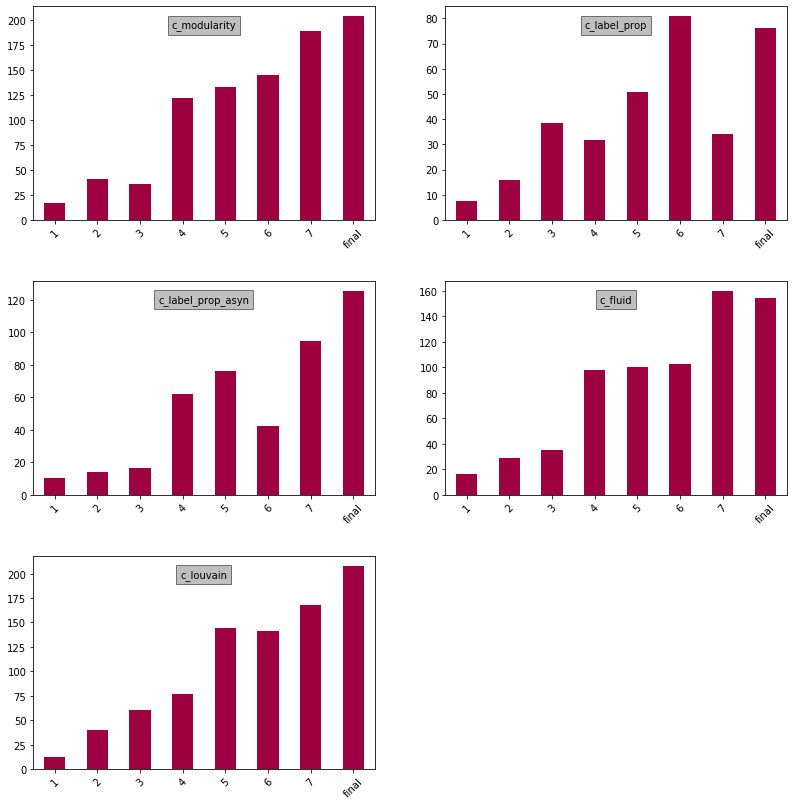

In [25]:
colnames = tslice_chi2a_df.columns

print('chi-square a')
series_list = [tslice_chi2a_df.iloc[i] for i in range(len(tslice_chi2a_df))]
create_plot_grid(series_list)

chi-square b


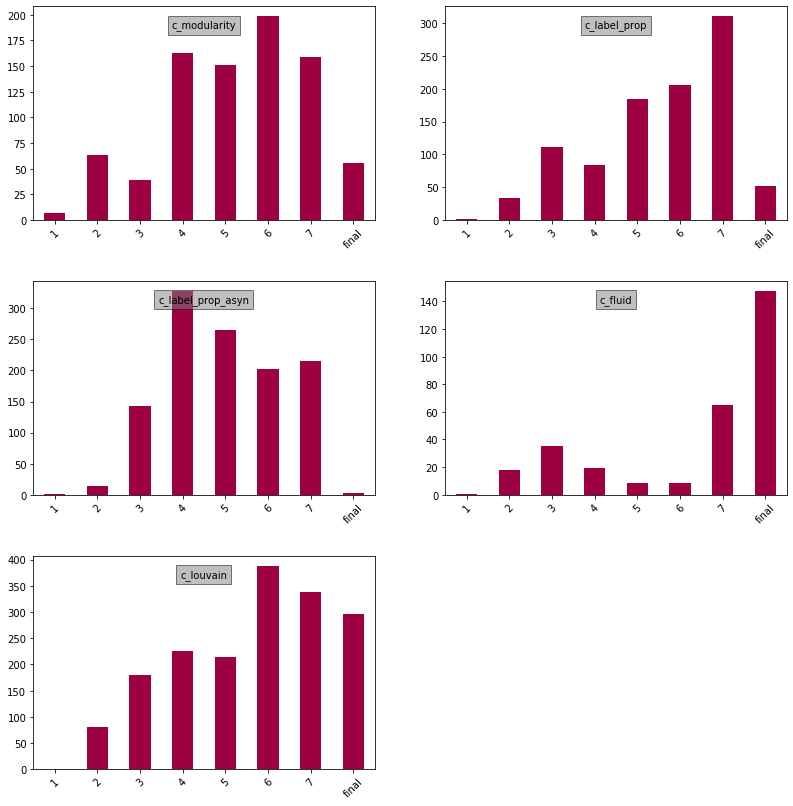

In [26]:
print('chi-square b')
series_list = [tslice_chi2b_df.iloc[i] for i in range(len(tslice_chi2b_df))]
create_plot_grid(series_list)

Cramer's v


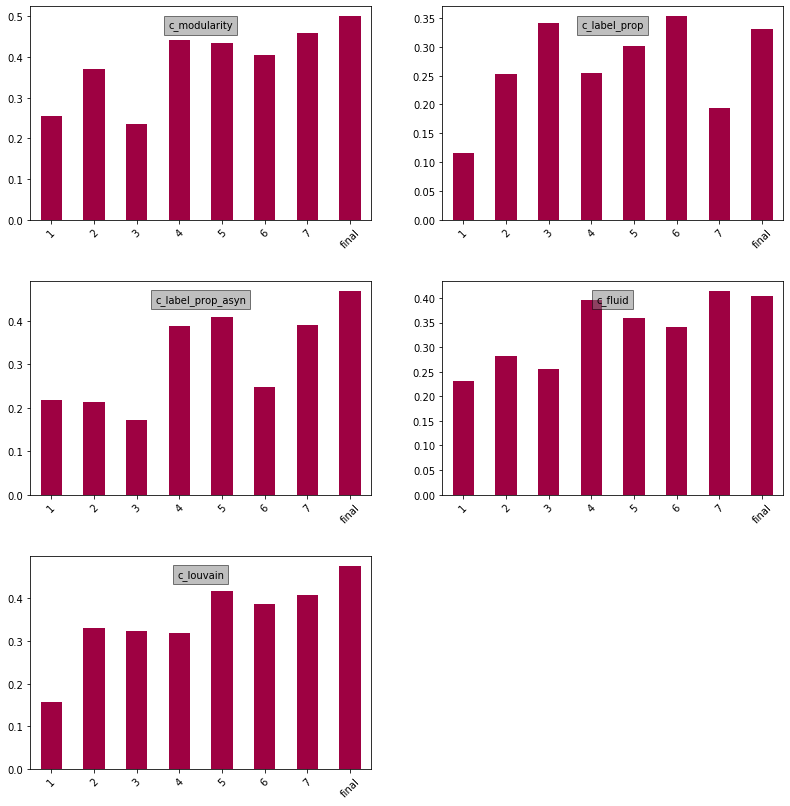

In [27]:
print('Cramer\'s v')
series_list = [tslice_cramers_df.iloc[i] for i in range(len(tslice_cramers_df))]
create_plot_grid(series_list)

Theil's U


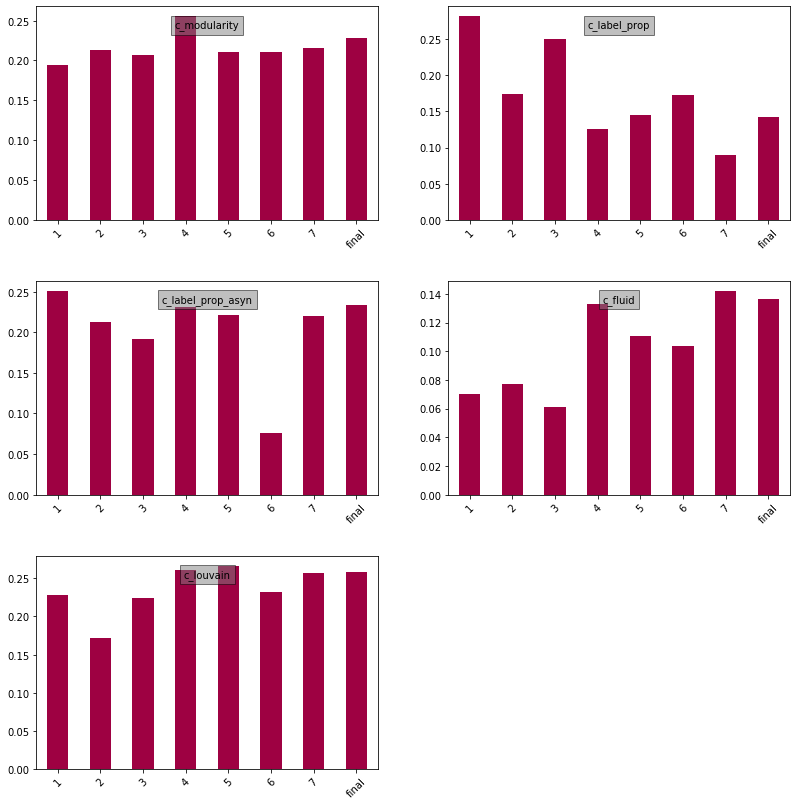

In [28]:
print('Theil\'s U')
series_list = [tslice_theils_df.iloc[i] for i in range(len(tslice_theils_df))]
create_plot_grid(series_list)

RF Feature Importance


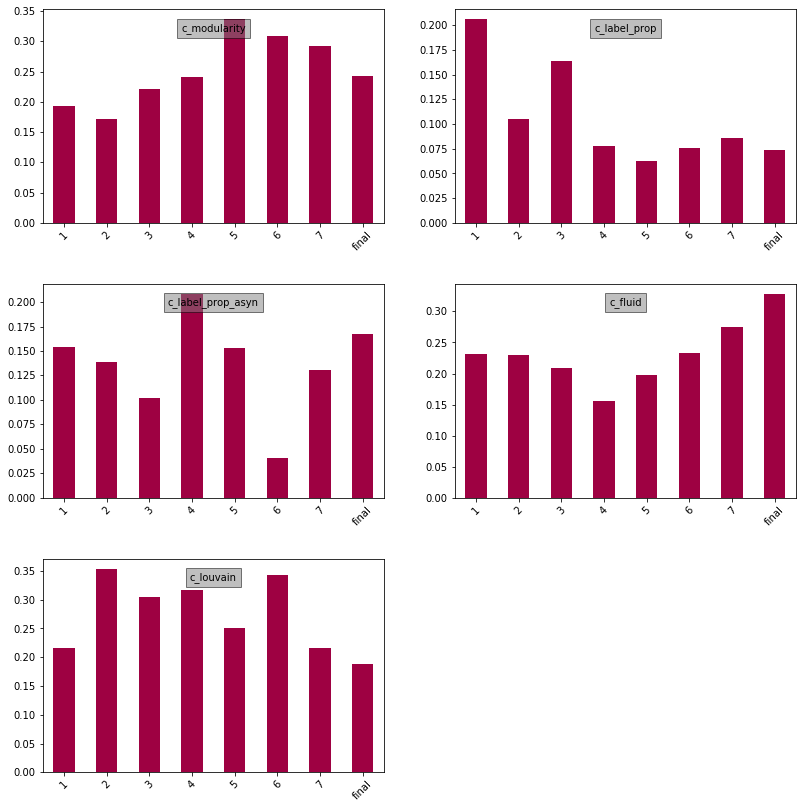

In [29]:
print('RF Feature Importance')
series_list = [tslice_rf_df.iloc[i] for i in range(len(tslice_rf_df))]
create_plot_grid(series_list)

The stability in the Theil's U and Random Forest metrics suggest that the associations are strong even in smaller graphs. Therefore using these community data throughout the collection process in live classification is a viable strategy. Theil's U measures the fraction of Y (witness labels) we can predict using the community measures. The highest and most stable over time algorithms therefore appear to be c_modularity, c_label_prop_async, and c_louvain. Each of these shows a value of approximately .20-.25 over the course of the collection period.

As community labels are qualitative, we now need to convert them to quantifiable metrics so that we can train a model that is able to generalise to new data (rather than simply learning the community label name). 

## Quantifying Community Structure

The analysis above has measured whether there is an association between the (qualitative) community label, and the target class. This association has been shown to exist, meaning 'witness' users tend to co-appear in certain communities. To be able to use community data in a machine-learning model, the communities labels must be converted into a value which can be generalised to new datasets. A clustering algorithm may label communities arbitrarily and this will be different on each dataset, therefore these labels must be converted into some measure that can be generalised between datasets.

In the current structure, communities are ranked by size. This could be a suitable metric: perhaps witness accounts are most common in the largest community. This has been observed in the output of, for example, the `c_fluid` algorithm, but is not consistant with the other algorithms' labels.

In this section, various measures by which to characterise the communities are calculated, and their correlation to the target label is evaluated. In essence, we are hoping that the network structure within the communities with more 'witness' nodes is significantly different to the other communities.

In [225]:
def calc_network_metrics(G):
    ''' Calculates various metrics summarising a graph object '''
    # TODO: Consider evaluating reciprocal relationship rate.

    result_dict = {}
    
    # Create undirected graph:
    G = nx.Graph(G)
    #### TESTING ####
    if not nx.is_connected(G):
        print('ERROR: undirected graph not connected!')
        print([len(x) for x in nx.connected_components(G)])
        Gcc = max(nx.connected_components(G), key=len)
        G = G.subgraph(Gcc)
    #################
    n = len(G)
    
    result_dict['nodes'] = n
    result_dict['edges'] = G.number_of_edges()
    
    avg_degree = G.number_of_edges() / n
    result_dict['avg_degree'] = avg_degree
    
    avg_shortest_path_length = nx.average_shortest_path_length(G)
    result_dict['avg_shortest_path_length'] = avg_shortest_path_length
    
    # Generate Erdős-Rényi graph or a binomial graph.
    max_edges = n*(n-1)/2
    pr_edge = G.number_of_edges() / max_edges
    R = nx.gnp_random_graph(n, pr_edge)
    
    # Max shortest path (diameter) and expected diameter:
    result_dict['diameter'] = nx.diameter(G)
    # result_dict['ex_diameter'] = nx.diameter(nx.connected_component_subgraphs(R)[0])
    Rcc = max(nx.connected_components(R), key=len)
    result_dict['ex_diameter'] = nx.diameter(R.subgraph(Rcc))
    result_dict['diameter_diff'] = result_dict['diameter'] - result_dict['ex_diameter']
    
    # Transitivity: fraction of all possible triangles present in G. (global clustering)
    transitivity = nx.transitivity(G)
    result_dict['transitivity'] = transitivity
    ex_transitivity = nx.transitivity(R)
    result_dict['ex_transitivity'] = ex_transitivity
    result_dict['transitivity_diff'] = transitivity - ex_transitivity
    
    # Clustering: fraction of possible triangles through a node that exist
    avg_clustering = nx.average_clustering(G)
    result_dict['avg_clustering'] = avg_clustering
    
    # The degree centrality for a node v is the fraction of nodes connected to it
    degree_centrality = nx.degree_centrality(G)
    avg_degree_centrality = sum([v for k, v in degree_centrality.items()]) / n
    result_dict['avg_degree_centrality'] = avg_degree_centrality
    
    # Eigenvector centrality computes the centrality for a node based on the centrality of its neighbors.
    eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000)
    avg_eigenvector_centrality = sum([v for k, v in eigenvector_centrality.items()]) / n
    result_dict['avg_eigenvector_centrality'] = avg_eigenvector_centrality
    
    # Betweenness centrality of a node v is the sum of the fraction of all-pairs shortest paths that pass through v
    betweenness_centrality = nx.betweenness_centrality(G)
    avg_betweenness_centrality = sum([v for k, v in betweenness_centrality.items()]) / n
    result_dict['avg_betweenness_centrality'] = avg_betweenness_centrality
    
    # The load centrality of a node is the fraction of all shortest paths that pass through that node. (Load centrality is slightly different than betweenness)
    load_centrality = nx.load_centrality(G)
    avg_load_centrality = sum([v for k, v in load_centrality.items()]) / n
    result_dict['avg_load_centrality'] = avg_load_centrality
    
    # Closeness centrality [1] of a node u is the reciprocal of the sum of the shortest path distances from u to all n-1 other nodes
    closeness_centrality = nx.closeness_centrality(G)
    avg_closeness_centrality = sum([v for k, v in closeness_centrality.items()]) / n
    result_dict['avg_closeness_centrality'] = avg_closeness_centrality

    return result_dict
    

In [230]:
def get_network_metrics_df(subgraphs_dict, title=None):
    '''
    Calculate network metrics for each subgraph in dict.
    
    Saves output to file, which is returned if available
    to avoid recalculation
    '''

    # Return cached file if available.
    if title:
        filename = 'network_data_{}_comm_metrics_{}.csv'.format(EVENT_NAME, title)
        try:
            results_df = pd.read_csv(DIR + filename, index_col=0)
            print('Returning cached file...')
            return results_df
        except:
            pass
    
    results_df = pd.DataFrame()

    print('Total community subgraphs: ', len(subgraphs_dict))
    for k, v in subgraphs_dict.items():
        ### TESTING ###
        #if k != 12:
        #    continue
        ###############
        print('Calculating metrics for community ID: ', k)
        results = calc_network_metrics(v)    
        results_df[k] = results.values()

    results_df.index = results.keys()
    results_df = results_df.T

    if not results_df['nodes'].is_monotonic_decreasing:
        print('WARNING: Communities not sorted by size')

    # Save dataframe to cached file:
    if title:
        results_df.to_csv(DIR + filename)
        
    return results_df

In [222]:
def get_subgraphs_by_attr(G, attr, min_subgraph_size=0):
    '''
    Returns a dictionary of subgraphs of graph G
    based on the attribute passed.
    Dictionary is keyed by attribute label.
    '''
    subgraph_dict = {}
    node_data = list(nx.get_node_attributes(G, attr).values())
    labels = set(node_data)

    for label in labels:
        count = sum([1 for x in node_data if x == label])
        # Exclude subgraphs below provided threshold.
        if count < min_subgraph_size:
            continue
        # Node generator:
        nodes = ( node for node, data in G.nodes(data=True) if data.get(attr) == label )
        subgraph = G.subgraph(nodes)
        subgraph_dict[label] = subgraph
    return subgraph_dict

In [ ]:
# e = Event.objects.all()[0]
# filename = 'network_data_{}_comm.gexf'.format(e.name.replace(' ', ''))

# G = get_graph_object()
# G = calc_community_metrics(G, filename)

For now, we can focus on the most promising community algorithm labels identified above: `c_modularity`, `c_label_prop_asyn`, `c_fluid`, `c_louvain`.

We exclude communities smaller than 50.

For each algorithm we do the following:
* The complete graph is split by the algorithm's labels, and the network metrics for each subgraph are then calculated and stored in a dataframe.

* We then calculate the ratio of positive-classed 'witness' cases against the total classed cases. As coding was done at random, some communities will have very few classed cases and therefore their ratios may not be statistically significant.

* Once these ratios are added to the community results dataframe, we can sort by their value and inspect the various metrics for possible relationships -- ie. which network metrics are associated with the ratio of positive cases.

In [237]:
def get_community_metrics_df(G, comm_name, users_df, min_community_size=50):
    
    # Split graph by comm_name labels, and calculate network metrics per sub-graph:
    subgraphs_dict = get_subgraphs_by_attr(G, comm_name, min_community_size)
    results_df = get_network_metrics_df(subgraphs_dict, comm_name)

    # Calculate ratio of positive cases per community label and add to dataframe:
    users_df_for_comm = users_df.loc[users_df[comm_name].notna() == True]
    ratio_list = []
    total_list = []
    for comm_id in results_df.index:
        tot = users_df_for_comm.loc[users_df_for_comm[comm_name] == comm_id]
        pos = tot.loc[tot['coded_as_witness'] == 1]
        if tot.shape[0] > 0:
            ratio_list.append(pos.shape[0]/tot.shape[0])
        else:
            ratio_list.append(None)
        total_list.append(tot.shape[0])
    results_df['pos_ratio'] = ratio_list
    results_df['total_coded'] = total_list

    # Sort dataframe by pos_ratio (high to low)
    results_df = results_df.sort_values(by=['pos_ratio'], ascending=False).reset_index()
    results_df.rename(columns={'index': 'size_rank'}, inplace=True)

    return results_df

In [248]:
#comm_names = ['c_modularity', 'c_label_prop_asyn', 'c_fluid', 'c_louvain']
comm_names = ['c_label_prop_asyn']

for comm_name in comm_names:
    results_df = get_community_metrics_df(G, comm_name, users_df)
    
    #df_list = [results_df[[c]] for c in results_df.columns]
    #df_list_secondary = [results_df['pos_ratio']]
    #create_plot_grid(df_list, df_list_secondary, kind='line')
    
    # Trim by size of community and amount of cases coded within each:
    #min_community_size = 1000
    min_community_size = 0
    min_total_coded = 0

    results_sub_df = results_df.loc[
                                (results_df['nodes'] >= min_community_size) & 
                                (results_df['total_coded'] >= min_total_coded)
                                    ].reset_index(drop=True)
    
    df_list = [results_sub_df[[c]] for c in results_sub_df.columns]
    df_list_secondary = [results_sub_df['pos_ratio']]
    #create_plot_grid(df_list, df_list_secondary, kind='line')

Returning cached file...


In [251]:
# TODO:
# Why is there so few total_coded within the communities -- should be closer to 1500?
sum(results_sub_df['total_coded'])

113

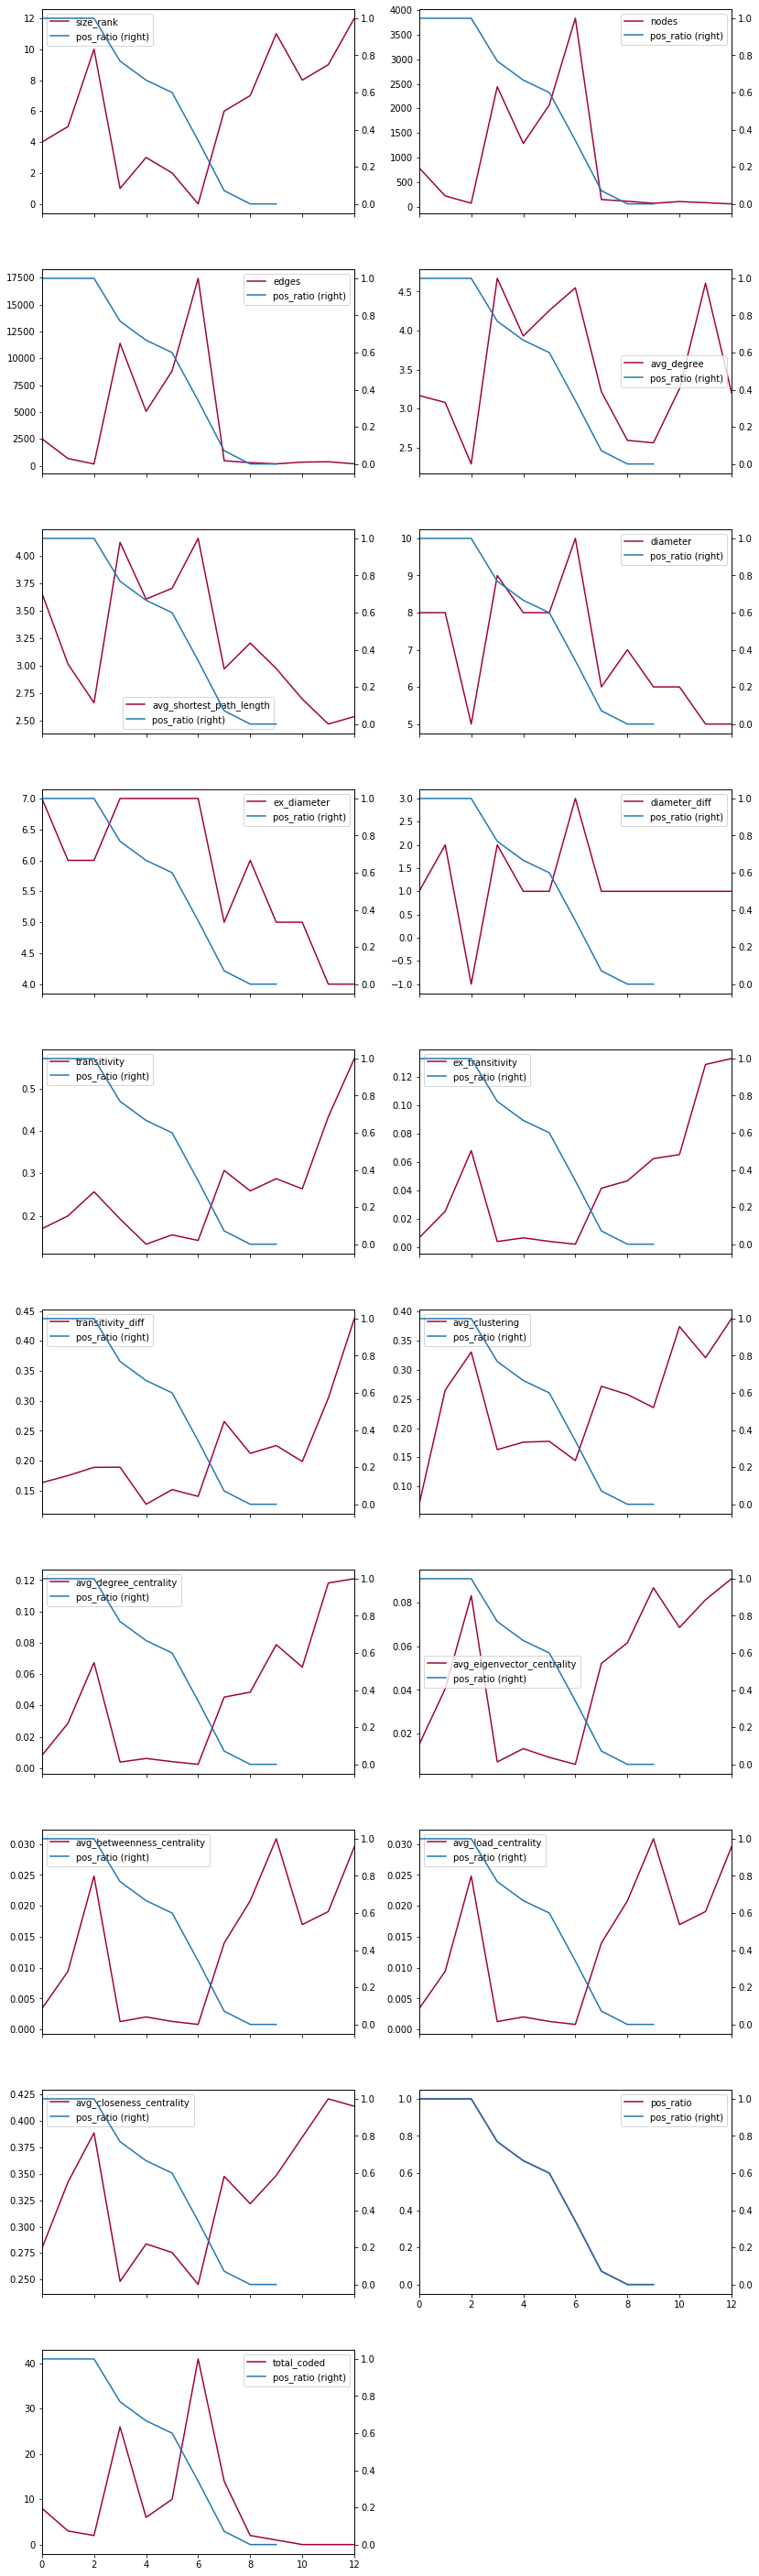

In [249]:
create_plot_grid(df_list, df_list_secondary, kind='line')

In [ ]:
# Stop running here

raise Exception

### Visual Inspection

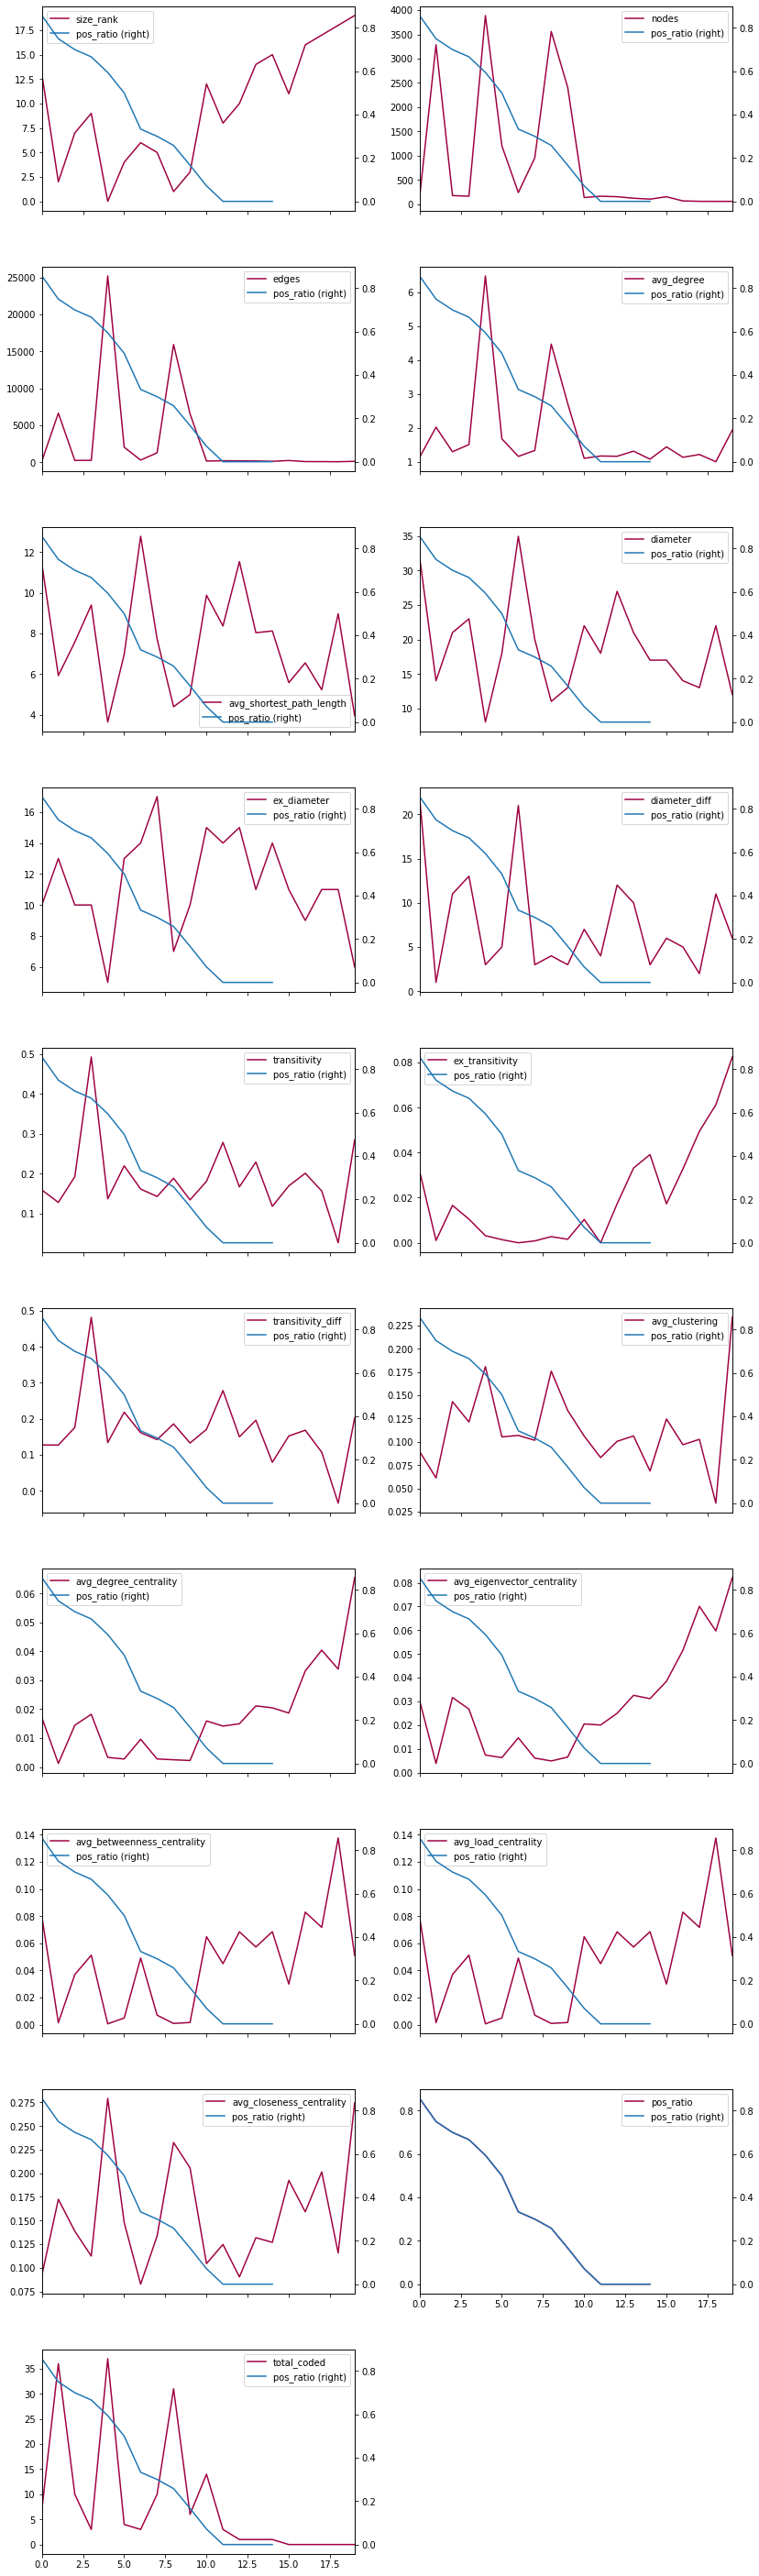

In [177]:
df_list = [results_df[[c]] for c in results_df.columns]
df_list_secondary = [results_df['pos_ratio']]

create_plot_grid(df_list, df_list_secondary, kind='line')

While there appears to be regular patterns in the data above, we must remember that many of the calculated metrics are influcenced by the size of the graph. As the size also influences the amount of coded examples within the graph, we cannot interpret these results meaningfully. For example, the four smallest graphs have ~60 nodes and no coded cases. Three graphs have zero positive cases, but only a single negative code, which isn't statistically significant. Therefore, we can drop communities below a certain size and re-examine the relationships.

As the network strutures appear as the size of the network grows, we can also exlude communities below a certain size:

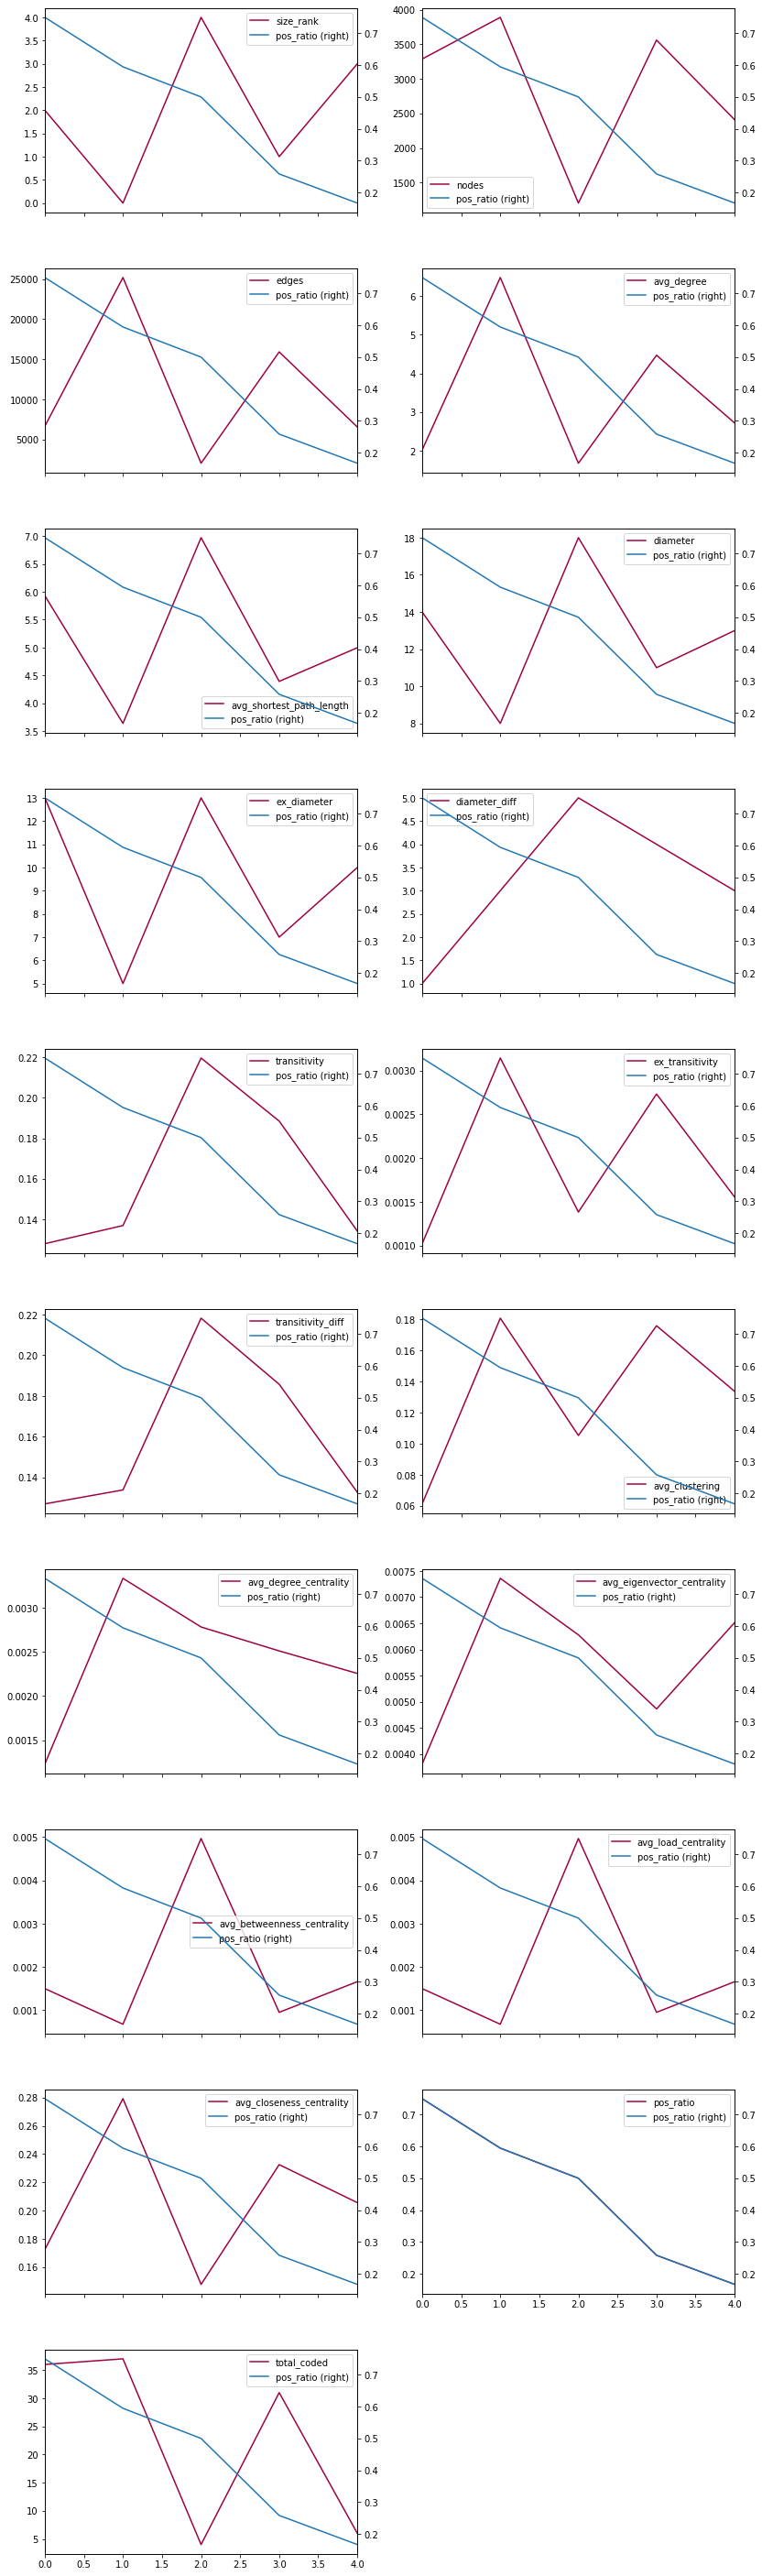

In [178]:
min_community_size = 1000
min_total_coded = 0

temp_df = tdf.loc[(tdf['nodes'] >= min_community_size) & (tdf['total_coded'] >= min_total_coded)].reset_index(drop=True)
df_list = [temp_df[[c]] for c in tdf.columns]
df_list_secondary = [temp_df[['pos_ratio']] for x in range(len(df_list))]

create_plot_grid(df_list, df_list_secondary, kind='line')

In [ ]:
temp_df